In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import astropy.units as u
from scipy.special import erf
from scipy.optimize import curve_fit

## Calibration

In [2]:
plt.style.use('sty.mplstyle')

In [3]:
Vs = np.array([40, 50, 60, 70, 80, 90, 100,125, 150,175, 200, 700, 1000, 1200]) * 1e-3
Q = 0.4095 * 1e-12  * Vs
E = 2.26e13 * Q
E

array([ 0.370188 ,  0.462735 ,  0.555282 ,  0.647829 ,  0.740376 ,
        0.832923 ,  0.92547  ,  1.1568375,  1.388205 ,  1.6195725,
        1.85094  ,  6.47829  ,  9.2547   , 11.10564  ])

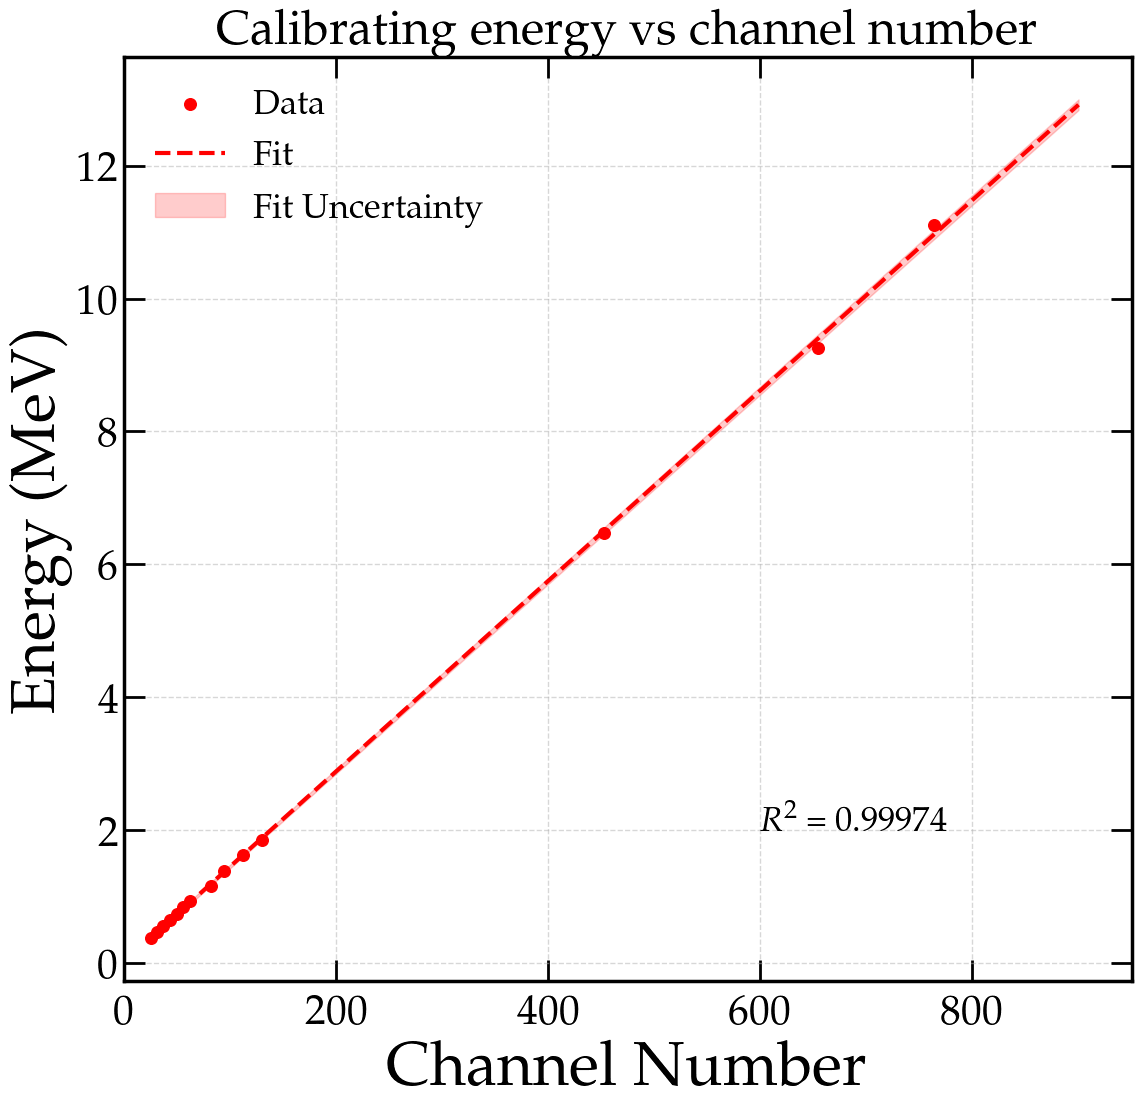

In [4]:
channels = [25, 31, 37, 43, 50, 56, 62, 82, 94, 112, 130,453, 654, 764]
# y = np.polyfit(channels, E, 1)

def linear_func(x, m, b):
    return m * x + b
y, pcov = curve_fit(linear_func, channels, E)
xs = np.linspace(25, 900, 100)

plt.scatter(channels, E, color = 'red',marker = 'o', s = 70)
plt.xlim(0, 950)   
plt.plot(xs, y[0] * xs + y[1], color = 'red', linestyle = '--')
plt.fill_between(xs,
                (y[0] - np.sqrt(pcov[0][0])) * xs + (y[1] - np.sqrt(pcov[1][1])),
                (y[0] + np.sqrt(pcov[0][0])) * xs + (y[1] + np.sqrt(pcov[1][1])),
                color = 'red', alpha = 0.2)
plt.grid(linestyle = '--', alpha = 0.5)
# r-squared
y_fit = linear_func(np.array(channels), y[0], y[1])
ss_res = np.sum((E - y_fit) ** 2)
ss_tot = np.sum((E - np.mean(E)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
plt.text(600, 2, f'$R^2$ = {r_squared:.5f}', fontsize = 25)
plt.ylabel('Energy (MeV)')
plt.xlabel('Channel Number')
plt.legend(['Data', 'Fit', 'Fit Uncertainty'], fontsize = 25)
plt.title('Calibrating energy vs channel number')
plt.savefig('./Plots/energy_calibration.png', dpi = 1000)

# r-squared


In [5]:
distance = np.array([9.4, 9.75, 10, 10.25, 10.5, 11]) - 6.58
distance_err = 0.13
total_counts = np.array([5168,5207,5137,5036,3801, 10])
channel_number = np.array([162, 124.86, 93.55, 55.34, 18.74, 0])
fwhm = np.array([11.372, 13.208, 14.871, 16.399 , 14.455, 0])
peak_count = np.array([384, 360, 320, 269, 246, 3])
peak_uncertainty = 1.44

Fitted equation: E^2 = -6.3767 * d + 23.9918


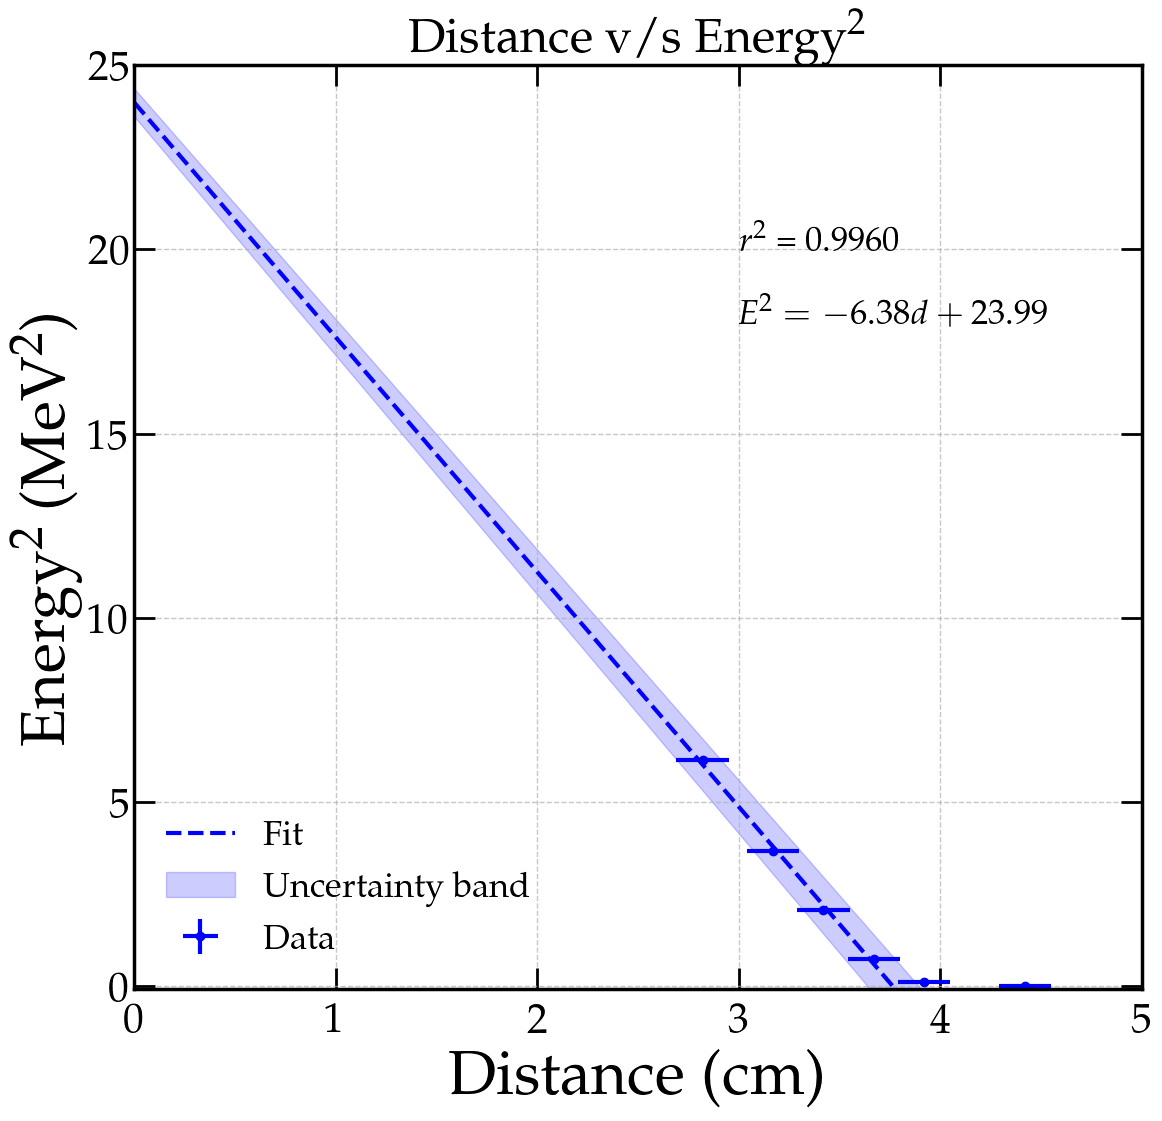

In [6]:
energies = y[1] * channel_number + y[0]
energies_uncertainty = peak_uncertainty * y[1] + y[0]
plt.errorbar(distance, energies**2, xerr = distance_err, yerr = energies_uncertainty, fmt = 'o', label = 'Data', color = 'blue')

Y_fit = np.polyfit(distance[0:-2], energies[0:-2]**2, 1)

def linear_func(x, m, c):
    return m * x + c
popt, pcov = curve_fit(linear_func, distance[0:-2], energies[0:-2]**2, sigma = 2 * energies_uncertainty * np.ones_like(energies[0:-2]), absolute_sigma = True)


xs = np.linspace(0, 5, 100)
# plt.plot(xs, Y_fit[0] * xs + Y_fit[1], color = 'green', linestyle = '--')   
plt.plot(xs, linear_func(xs, *popt), color = 'blue', linestyle = '--', label = 'Fit')
plt.fill_between(xs, linear_func(xs, *(popt - np.sqrt(np.diag(pcov)))), linear_func(xs, *(popt + np.sqrt(np.diag(pcov)))), color = 'blue', alpha = 0.2, label = 'Uncertainty band')
plt.xlabel('Distance (cm)')
plt.ylabel(r'Energy$^2$ (MeV$^2$)')
plt.title(r'Distance v/s Energy$^2$')
plt.ylim(-0.1, 25)
plt.xlim(0, 5)
# r-squared
residuals = energies[0:-2]**2 - linear_func(distance[0:-2], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((energies[0:-2]**2 - np.mean(energies[0:-2]**2))**2)
r_squared = 1 - (ss_res / ss_tot)
plt.text(3, 20, f'$r^2$ = {r_squared:.4f}', fontsize = 25)
# equation
print(f'Fitted equation: E^2 = {popt[0]:.4f} * d + {popt[1]:.4f}')
plt.text(3, 18, r'$E^2 = -6.38d + 23.99$', fontsize = 25)
plt.legend( fontsize = 25)
plt.grid(linestyle = '--', alpha = 0.7)
plt.savefig('./Plots/distance_vs_E.png', dpi = 1000)

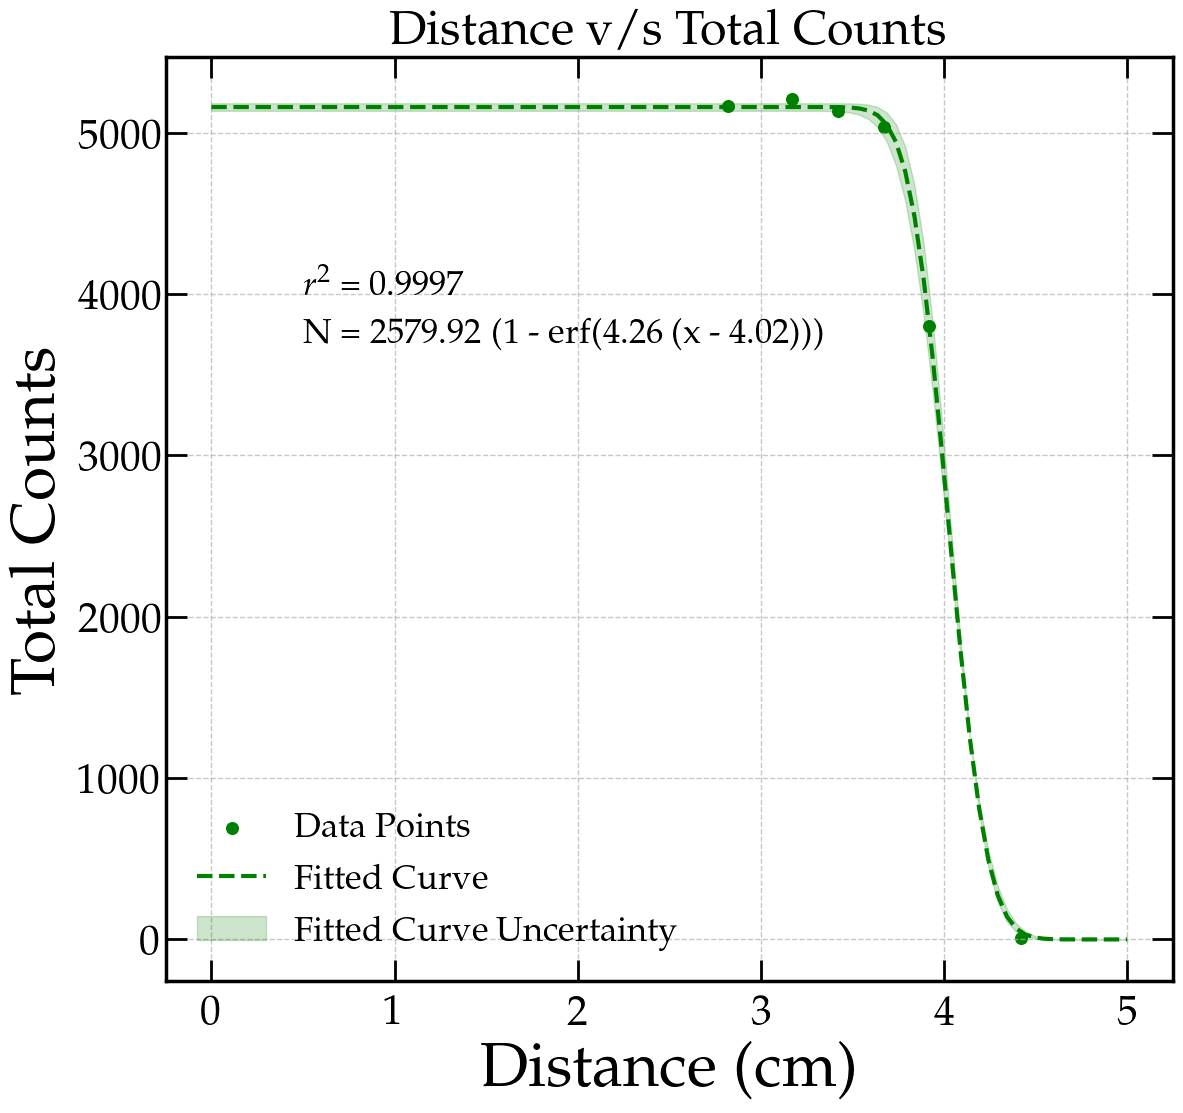

In [7]:
plt.scatter(distance, total_counts,  color = 'green',s=70)
def erf_func(x, a, b, c):
    return a * (1 - erf(b * (x - c)))
popt_counts, pcov_counts = curve_fit(erf_func, distance, total_counts, p0 = [5000, 1, 4], maxfev = 10000)
xs = np.linspace(0, 5, 100)
plt.plot(xs, erf_func(xs, *popt_counts), color = 'green', linestyle = '--')
plt.fill_between(xs, erf_func(xs, *(popt_counts - np.sqrt(np.diag(pcov_counts)))), erf_func(xs, *(popt_counts + np.sqrt(np.diag(pcov_counts)))), color = 'green', alpha = 0.2)
plt.grid(linestyle = '--', alpha = 0.7)
# r-squared
residuals_counts = total_counts - erf_func(distance, *popt_counts)
ss_res_counts = np.sum(residuals_counts**2)
ss_tot_counts = np.sum((total_counts - np.mean(total_counts))**2)
r_squared_counts = 1 - (ss_res_counts / ss_tot_counts)
plt.text(0.5, 4000, f'$r^2$ = {r_squared_counts:.4f}', fontsize = 25)
# equation
plt.text(0.5, 3700, f'N = {popt_counts[0]:.2f} (1 - erf({popt_counts[1]:.2f} (x - {popt_counts[2]:.2f})))', fontsize = 25)
plt.legend([ 'Data Points','Fitted Curve', 'Fitted Curve Uncertainty'], fontsize = 25)
plt.xlabel('Distance (cm)')
plt.ylabel('Total Counts')
plt.title('Distance v/s Total Counts')
plt.savefig('./Plots/distance_vs_counts.png', dpi = 1000)

## Air

In [8]:
d = 10.9 - 6.58
err = 0.13

In [9]:
Ps = [(52.5 + 51.7) / 2, (107.4 + 108.0) / 2,  (173.1 + 173.8) / 2, (213.1 + 212.5) / 2, (258.7 + 259.2) / 2, (306.7 + 306.1) / 2, (357.4 + 358.0) / 2, (408.7 + 409.1) / 2, (453.6 + 454.0) / 2, (519.8 + 520) / 2, (576.9 + 577.1) / 2, (630 + 630.1) / 2, (680 + 680) / 2, (705.1  + 704.9) / 2, (720.4 + 720.5) / 2, (732.2 + 732.2) / 2,  756]
deltaP = [(52.5 - 51.7), (108 - 107.4), (173.8 - 173.1), (213.1 - 212.5), (259.2 - 258.7), (306.7 - 306.1), (358.0 - 357.4), (409.1 - 408.7), (454.0 - 453.6), (520.0 - 519.8), (577.1 - 576.9), (630.1 - 630.0), (680 - 680),(704.9 - 705.1), (720.4 - 720.5), 0, 0 ]
Ps = np.array(Ps)
deltaP = np.array(deltaP)
x_eff = (d * Ps) / 756
delta_x_eff = (deltaP * d) / 756 
delta_x_eff = np.sqrt(delta_x_eff**2 + err**2)

In [10]:
def file_analysis(filename):
    data = pd.read_csv(filename, skiprows = 12, skipfooter=1, engine='python', header=None)
    data.columns = ['Counts']
    data['Channels'] = np.linspace(1, len(data), len(data))
    data['Counts'] = pd.to_numeric(data['Counts'], errors='coerce')
    max_counts = data['Counts'].max()
    peak_channel = data['Channels'][data['Counts'].idxmax()]
    weighted_mean = np.average(data['Channels'], weights=data['Counts'])
    variance = np.average((data['Channels'] - weighted_mean) ** 2, weights=data['Counts'])
    std_dev = np.sqrt(variance)
    
    energy = y[0] * peak_channel + y[1]
    energy_uncertainty = std_dev * y[0] + y[1]
    
    total_counts = data['Counts'].sum()
    return peak_channel, max_counts, energy, energy_uncertainty, total_counts

In [11]:
string = '../Alpha Range/Air Pressure/airP'
numbers = [52, 107.5, 173.4, 212.6, 259, 306.3, 357, 408.5, 453, 519, 577, 630, 680,704, 720, 732, 756]
filenames = [f"{string}{num}.asc" for num in numbers]  # Properly construct filenames
peak_channels = []
max_counts = []
energies = []
energies_uncertainties = []
total_counts_list = []
for file in filenames:
    pc, mc, en, std, t = file_analysis(file)
    peak_channels.append(pc)
    max_counts.append(mc)
    energies.append(en)
    energies_uncertainties.append(std)
    total_counts_list.append(t)

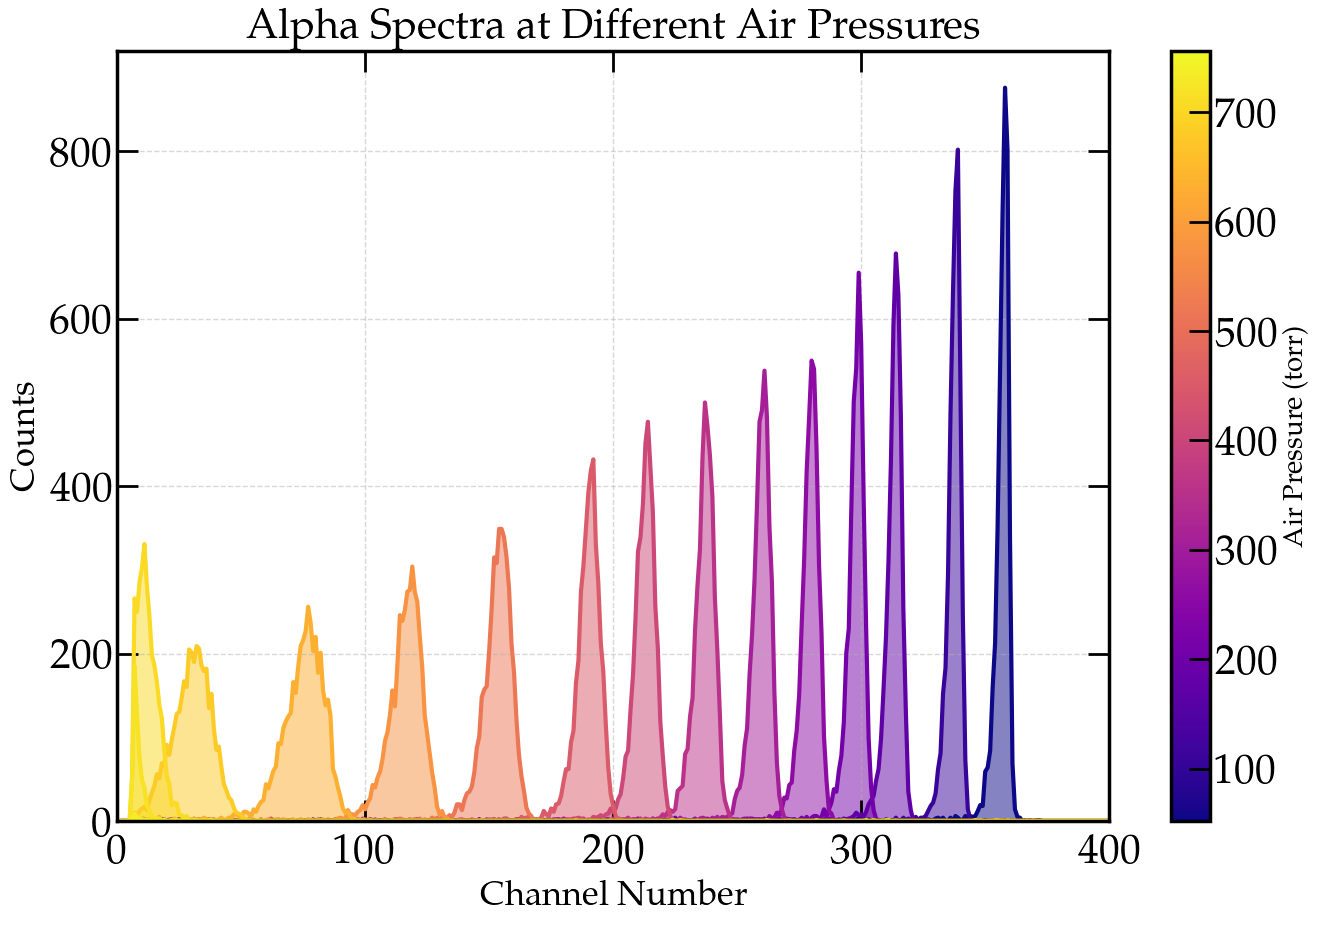

In [12]:
# make a colorbar norm for nums
norm = plt.Normalize(vmin=min(numbers), vmax=max(numbers))
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
fig, ax = plt.subplots(figsize = (16, 10))
for file in filenames:
    data = pd.read_csv(file, skiprows = 12, skipfooter=1, engine='python', header=None)
    data.columns = ['Counts']
    data['Channels'] = np.linspace(1, len(data), len(data))
    data['Counts'] = pd.to_numeric(data['Counts'], errors='coerce')
    ax.bar(data['Channels'], data['Counts'], width=1, alpha=0.5, color=plt.cm.plasma(norm(float(file.split('airP')[-1].split('.asc')[0]))))
    ax.plot(data['Channels'], data['Counts'], color=plt.cm.plasma(norm(float(file.split('airP')[-1].split('.asc')[0]))))
    #plt.plot([], [], color=plt.cm.viridis(norm(float(file.split('airP')[-1].split('.asc')[0]))), label=f'Pressure: {file.split("airP")[-1].split(".asc")[0]} torr')
ax.set_xlabel('Channel Number', fontsize = 25)
ax.set_ylabel('Counts', fontsize = 25)
ax.set_xlim(0, 400)
ax.grid(linestyle = '--', alpha = 0.5)

# set colorbar fontsize = 20
fig.colorbar(sm, ax = ax, label='Air Pressure (torr)').ax.yaxis.label.set_size(20)
ax.set_title('Alpha Spectra at Different Air Pressures', fontsize = 30)
fig.savefig('./Plots/alpha_spectra_air_pressure.png', dpi = 1000)
#ax.legend(title='Air Pressure', bbox_to_anchor=(1.05, 1), loc='upper left')

In [13]:
d

4.32

R-squared for Effective Distance vs Energy^2: 0.9569351490237243


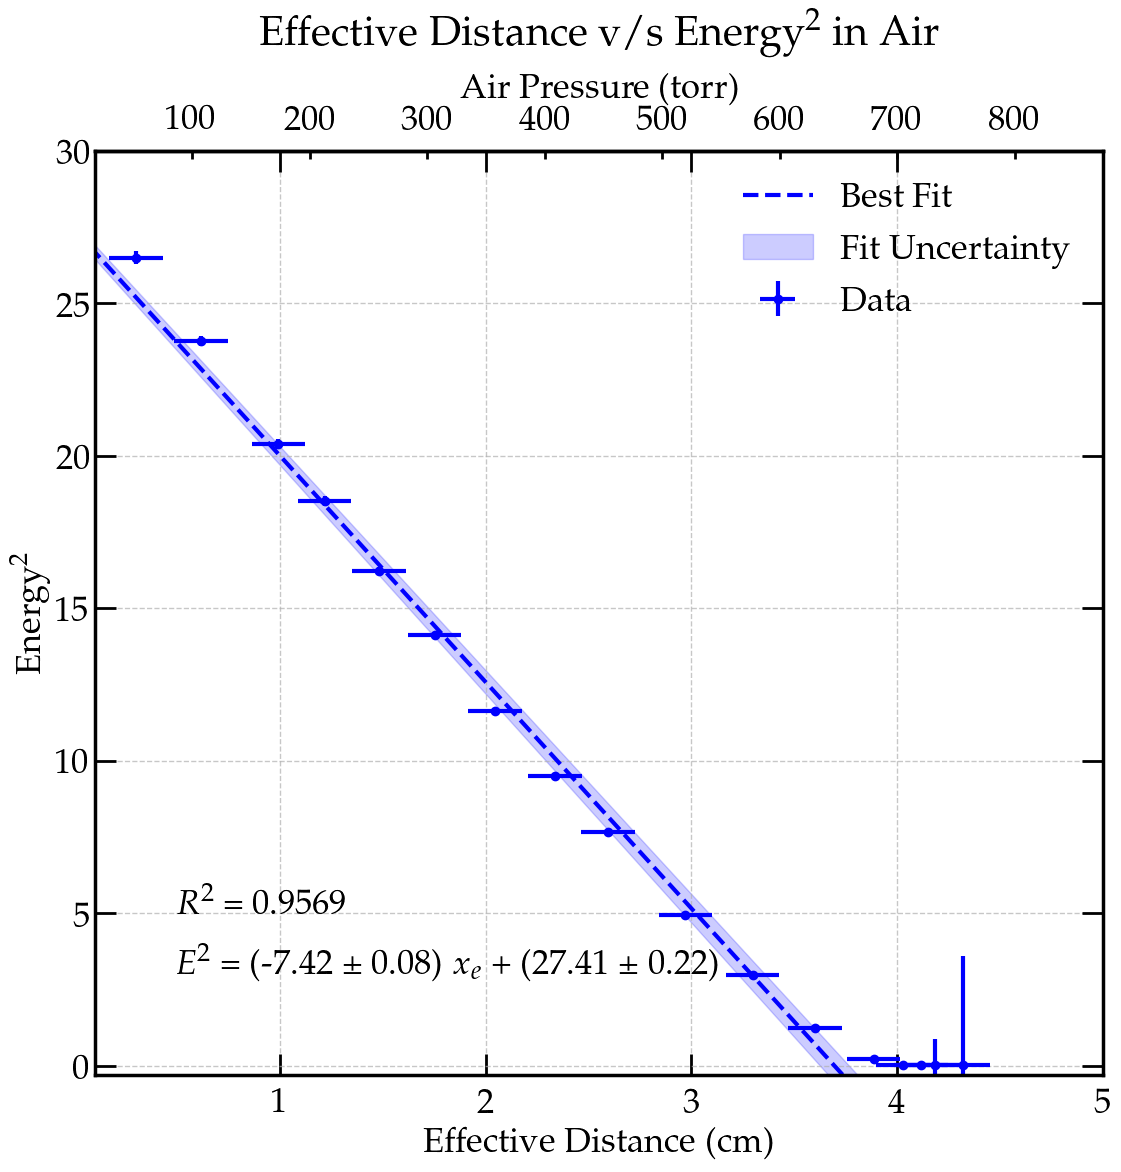

In [39]:

plt.errorbar(x_eff, np.array(energies)**2, xerr=delta_x_eff, yerr=np.array(energies_uncertainties)**2, fmt ='o', color = 'blue', label = 'Data')
plt.xlim(-0.1, 5)
plt.ylim(0, 30)

def curve_fit_func(x, m, c):
    return m * x + c

d = 10.9 - 6.58
def x_to_Pressure(x_eff):
    return (x_eff * 756) / 4.32

def Pressure_to_x(P):
    return (4.32 * P) / 756

# Y_fit2 = np.polyfit(x_eff[0:-3], np.array(energies[0:-3])**2, 1)
# xs = np.linspace(0, 5, 100)
popt, pcov = curve_fit(curve_fit_func, x_eff[0:-5], np.array(energies[0:-5])**2, sigma = np.array(energies_uncertainties[0:-5]), absolute_sigma = True)
Y_fit2 = popt
xs = np.linspace(0, 5, 100)
plt.plot(xs, Y_fit2[0] * xs + Y_fit2[1], color = 'blue', linestyle = '--', label = 'Best Fit')
plt.fill_between(xs,
                    curve_fit_func(xs, *(Y_fit2 - np.sqrt(np.diag(pcov)))),
                    curve_fit_func(xs, *(Y_fit2 + np.sqrt(np.diag(pcov)))),
                    color='blue', alpha=0.2, label='Fit Uncertainty')
# add another axis on the top which shows the pressure corresponding to effective distance

ax2 = plt.gca().secondary_xaxis('top', functions=(x_to_Pressure, Pressure_to_x))
pressure_ticks = [100, 200, 300, 400, 500, 600, 700, 800]
ax2.set_xticks(pressure_ticks,labels =[str(tick) for tick in pressure_ticks], fontsize = 25)
# I want the ticks to be inside the plot
ax2.tick_params(axis='x', which='both', direction='in', length=6)
ax2.set_xlabel('Air Pressure (torr)', fontsize = 25)

# plt.plot(xs, Y_fit2[0] * xs + Y_fit2[1], color = 'blue', linestyle = '--')
plt.xlabel('Effective Distance (cm)', fontsize = 25)
plt.ylabel(r'Energy$^2$', fontsize = 25)
plt.title(r'Effective Distance v/s Energy$^2$ in Air', pad = 20, fontsize = 30)

plt.xlim(0.1, 5)
plt.ylim(-0.3, 30)
# r-squared
y_mean = np.mean(np.array(energies)**2)
ss_tot = np.sum((np.array(energies)**2 - y_mean)**2)
ss_res = np.sum((np.array(energies)**2 - (Y_fit2[0] * x_eff + Y_fit2[1]))**2)
r_squared = 1 - (ss_res / ss_tot)
plt.text(0.5, 5, f'$R^2$ = {r_squared:.4f}', fontsize = 25)
print(f"R-squared for Effective Distance vs Energy^2: {r_squared}")
# print the best fit line equation with uncertainties on the plot 
eff = 'eff'
plt.text(0.5, 3, f'$E^2$ = ({Y_fit2[0]:.2f} ± {np.sqrt(pcov[0,0]):.2f}) $x_e$ + ({Y_fit2[1]:.2f} ± {np.sqrt(pcov[1,1]):.2f})', fontsize = 25)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(frameon = False, fontsize = 25)
plt.savefig('./Plots/effective_distance_vs_E_air.png', dpi = 1000)



In [37]:
def erf_fit_for_total_count(x, N_0, alpha, x0):
    return N_0 * (1 - erf(alpha * (x - x0)))

curve_fit_params, covariance = curve_fit(erf_fit_for_total_count, x_eff, total_counts_list, p0=[5000, 1, 2])

R-squared for Effective Distance vs Total Counts: 0.99271911647164


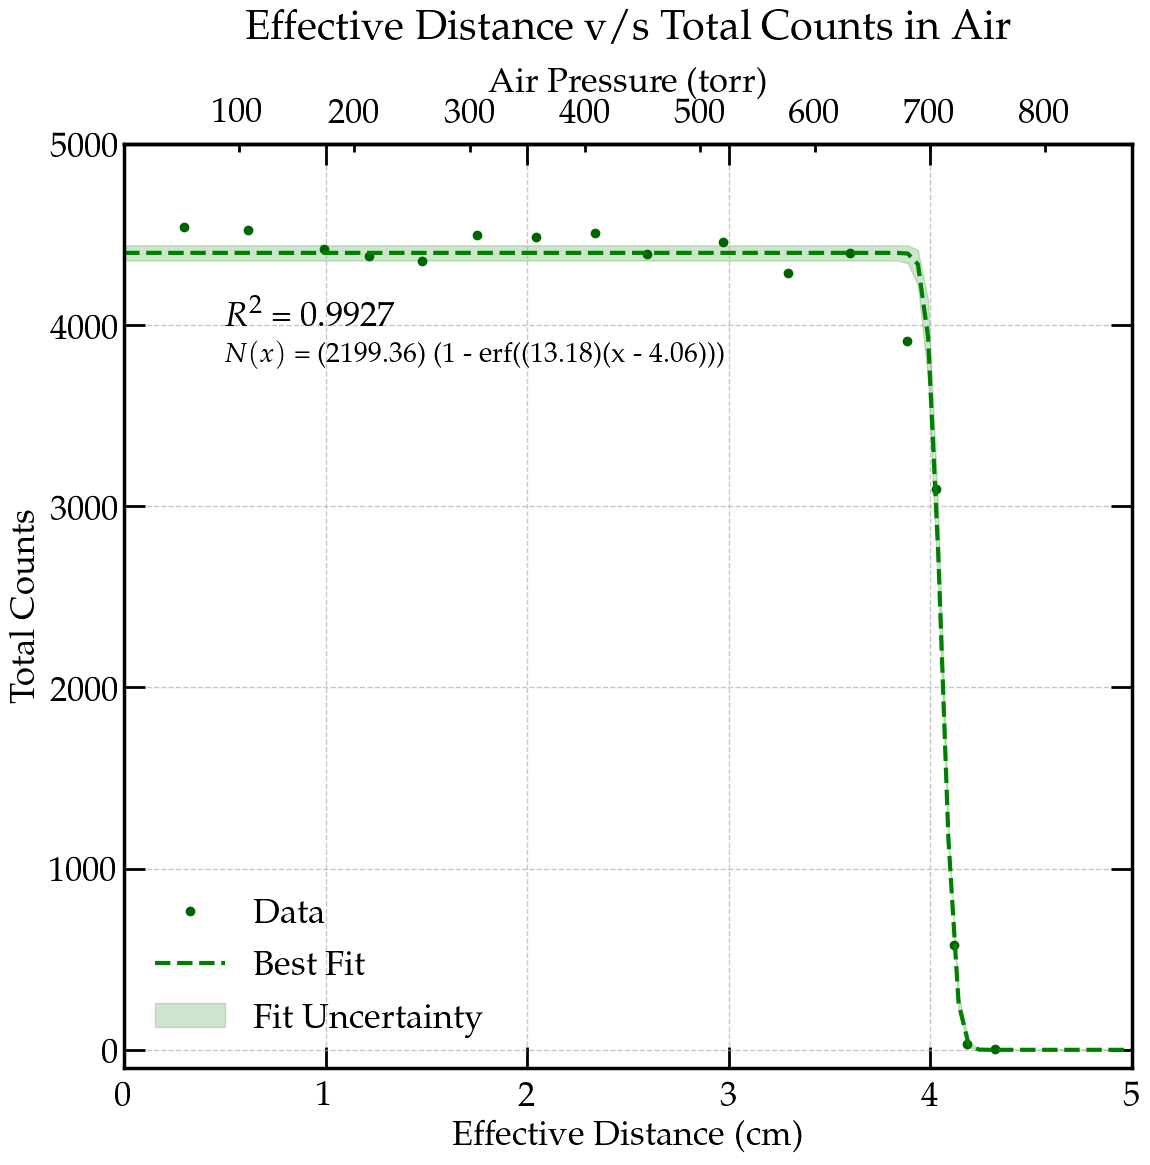

In [45]:
plt.plot(x_eff, total_counts_list, 'o', color = 'darkgreen', label = 'Data')
xs = np.linspace(0, 5, 100)
plt.plot(xs, erf_fit_for_total_count(xs, *curve_fit_params), color = 'green', linestyle = '--', label = 'Best Fit')
plt.fill_between(xs,
                    erf_fit_for_total_count(xs, *(curve_fit_params + np.sqrt(np.diag(covariance)))),
                    erf_fit_for_total_count(xs, *(curve_fit_params - np.sqrt(np.diag(covariance)))),
                    color='green', alpha=0.2, label='Fit Uncertainty')
plt.xlabel('Effective Distance (cm)', fontsize = 25)
plt.xlim(0, 5)
plt.ylim(-100, 5000)
plt.grid(linestyle='--', alpha=0.7)
plt.ylabel('Total Counts', fontsize = 25)
plt.legend(frameon = False, fontsize = 25)
plt.title('Effective Distance v/s Total Counts in Air', pad = 20, fontsize = 30)

ax2 = plt.gca().secondary_xaxis('top', functions=(x_to_Pressure, Pressure_to_x))
pressure_ticks = [100, 200, 300, 400, 500, 600, 700, 800]
ax2.set_xticks(pressure_ticks,labels =[str(tick) for tick in pressure_ticks], fontsize = 25)
# I want the ticks to be inside the plot
ax2.tick_params(axis='x', which='both', direction='in', length=6)
ax2.set_xlabel('Air Pressure (torr)', fontsize = 25)



# r-squared
y_mean_counts = np.mean(total_counts_list)
ss_tot_counts = np.sum((total_counts_list - y_mean_counts)**2)
ss_res_counts = np.sum((total_counts_list - erf_fit_for_total_count(x_eff, *curve_fit_params))**2)
r_squared_counts = 1 - (ss_res_counts / ss_tot_counts)
plt.text(0.5, 4000, f'$R^2$ = {r_squared_counts:.4f}', fontsize = 25)
plt.tick_params(axis='both', which='major', labelsize=25)
print(f"R-squared for Effective Distance vs Total Counts: {r_squared_counts}")
plt.text(0.5, 3800, f'$N(x)$ = ({curve_fit_params[0]:.2f}) (1 - erf(({curve_fit_params[1]:.2f})(x - {curve_fit_params[2]:.2f})))', fontsize = 20)

plt.savefig('./Plots/effective_distance_vs_total_counts_air.png', dpi = 1000)

## Argon

In [46]:
initialPs_argon = [84.7, 134.7, 196.5, 251.4, 313.2, 360.2, 429.3, 481.7, 541.4, 597.0, 646.5, 706.5, 747.7, 753.1, 761.6, 769.9, 785.2, 789.9]
finalPs_argon = [85.5, 135.4, 197.2, 252, 313.8, 360.8, 429.9, 482.2, 541.6, 596.8, 646.6, 706.5, 747.5, 753.1, 761.6, 770, 785.3, 789.9]
Ps_argon = np.array([(initial + final) / 2 for initial, final in zip(initialPs_argon, finalPs_argon)])
deltaPs_argon = np.array([(final - initial) for initial, final in zip(initialPs_argon, finalPs_argon)])
x_eff_argon = (d * Ps_argon) / 756
delta_x_eff_argon = (deltaPs_argon * d) / 756
delta_x_eff_argon = np.sqrt(delta_x_eff_argon**2 + err**2)

In [47]:
string = '../Alpha Range/Argon Pressure/ArP'
nums_arg = [84, 134, 197, 252, 313, 360, 429, 482, 541, 597, 646, 706, 747, 753, 761, 770, 785, 790]
filenames_argon = [f"{string}{num}.asc" for num in nums_arg]
peak_channels_argon = []
max_counts_argon = []
energies_argon = []
energies_uncertainties_argon = []
total_counts_list_argon = []
for file in filenames_argon:
    pc, mc, en, std, t = file_analysis(file)
    peak_channels_argon.append(pc)
    max_counts_argon.append(mc)
    energies_argon.append(en)
    energies_uncertainties_argon.append(std)
    total_counts_list_argon.append(t)

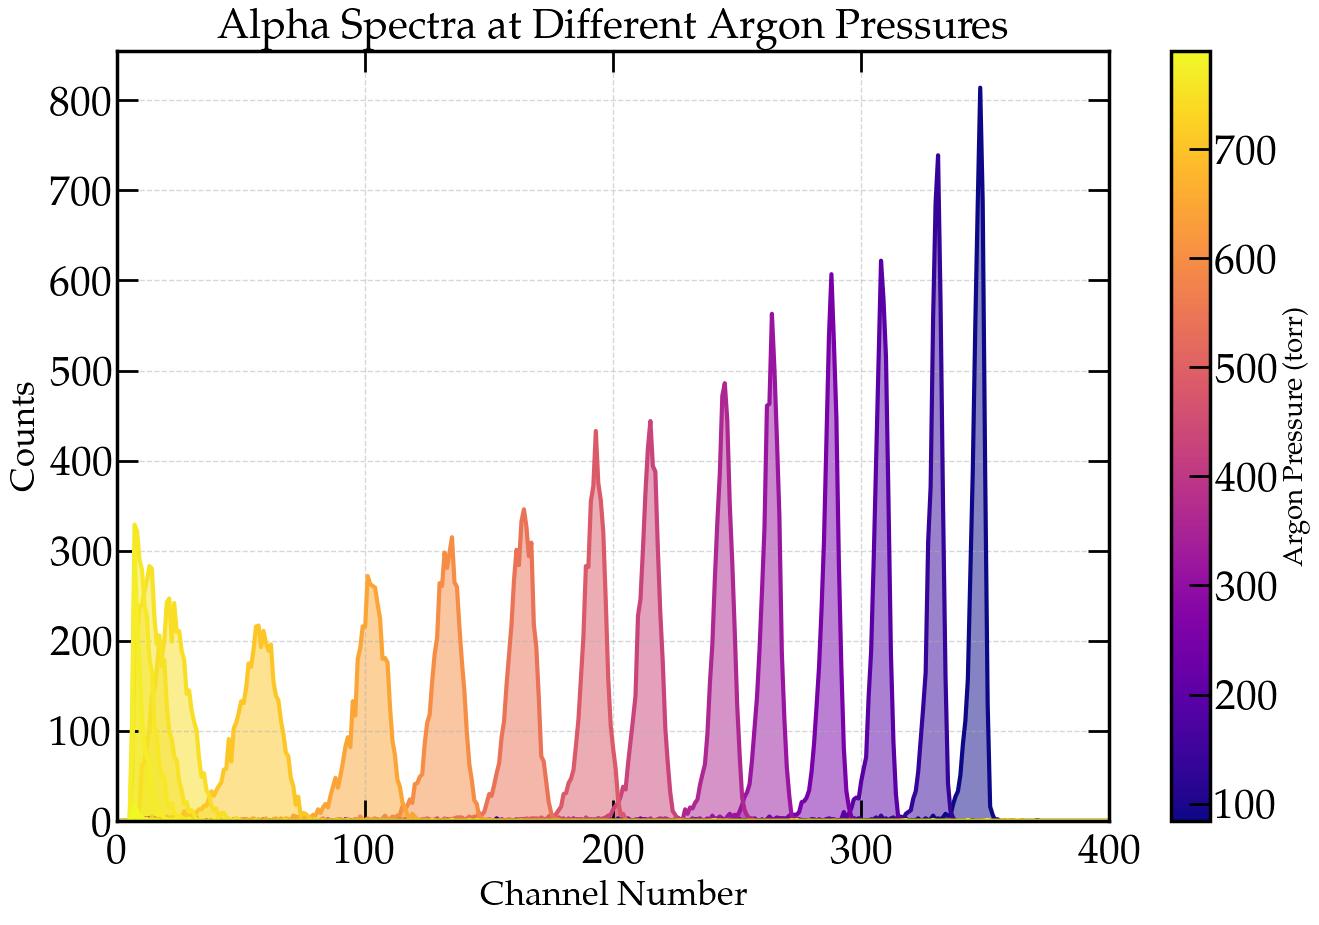

In [48]:
norm = plt.Normalize(vmin=min(nums_arg), vmax=max(nums_arg))
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
fig, ax = plt.subplots(figsize = (16, 10))
for file in filenames_argon:
    data = pd.read_csv(file, skiprows = 12, skipfooter=1, engine='python', header=None)
    data.columns = ['Counts']
    data['Channels'] = np.linspace(1, len(data), len(data))
    data['Counts'] = pd.to_numeric(data['Counts'], errors='coerce')
    ax.bar(data['Channels'], data['Counts'], width=1, alpha=0.5, color=plt.cm.plasma(norm(float(file.split('ArP')[-1].split('.asc')[0]))))
    ax.plot(data['Channels'], data['Counts'], color=plt.cm.plasma(norm(float(file.split('ArP')[-1].split('.asc')[0]))))
ax.set_xlabel('Channel Number', fontsize = 25)
ax.set_ylabel('Counts', fontsize = 25)
ax.set_xlim(0, 400)
ax.grid(linestyle = '--', alpha = 0.5)
fig.colorbar(sm, ax = ax, label='Argon Pressure (torr)').ax.yaxis.label.set_size(20)
ax.set_title('Alpha Spectra at Different Argon Pressures', fontsize = 30)
fig.savefig('./Plots/alpha_spectra_argon_pressure.png', dpi = 1000)


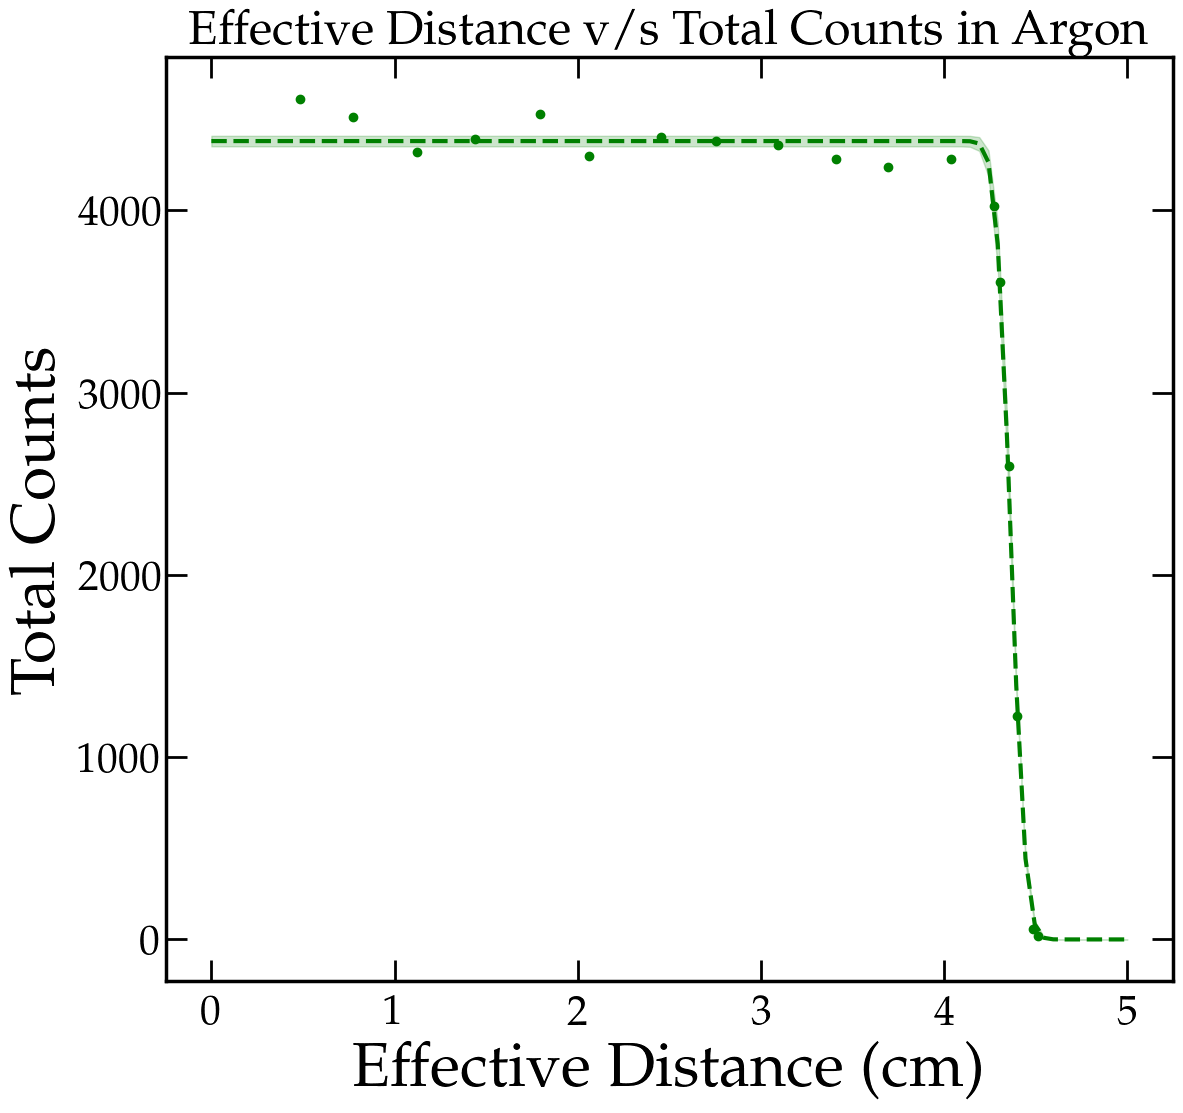

In [ ]:
plt.plot(x_eff_argon, total_counts_list_argon, 'o', color = 'green')
popt, pcov = curve_fit(erf_fit_for_total_count, x_eff_argon, total_counts_list_argon, p0=[5000, 1, 2])
xs = np.linspace(0, 5, 100)
plt.plot(xs, erf_fit_for_total_count(xs, *popt), color = 'green', linestyle = '--')
plt.fill_between(xs,
                    erf_fit_for_total_count(xs, *(popt + np.sqrt(np.diag(pcov)))),
                    erf_fit_for_total_count(xs, *(popt - np.sqrt(np.diag(pcov)))),
                    color='green', alpha=0.2, label='Fit Uncertainty')
plt.grid(linestyle = '--', alpha = 0.7)
# r-s

plt.xlabel('Effective Distance (cm)')
plt.ylabel('Total Counts')
plt.title('Effective Distance v/s Total Counts in Argon')
plt.savefig('./Plots/effective_distance_vs_total_counts_argon.png', dpi = 300)

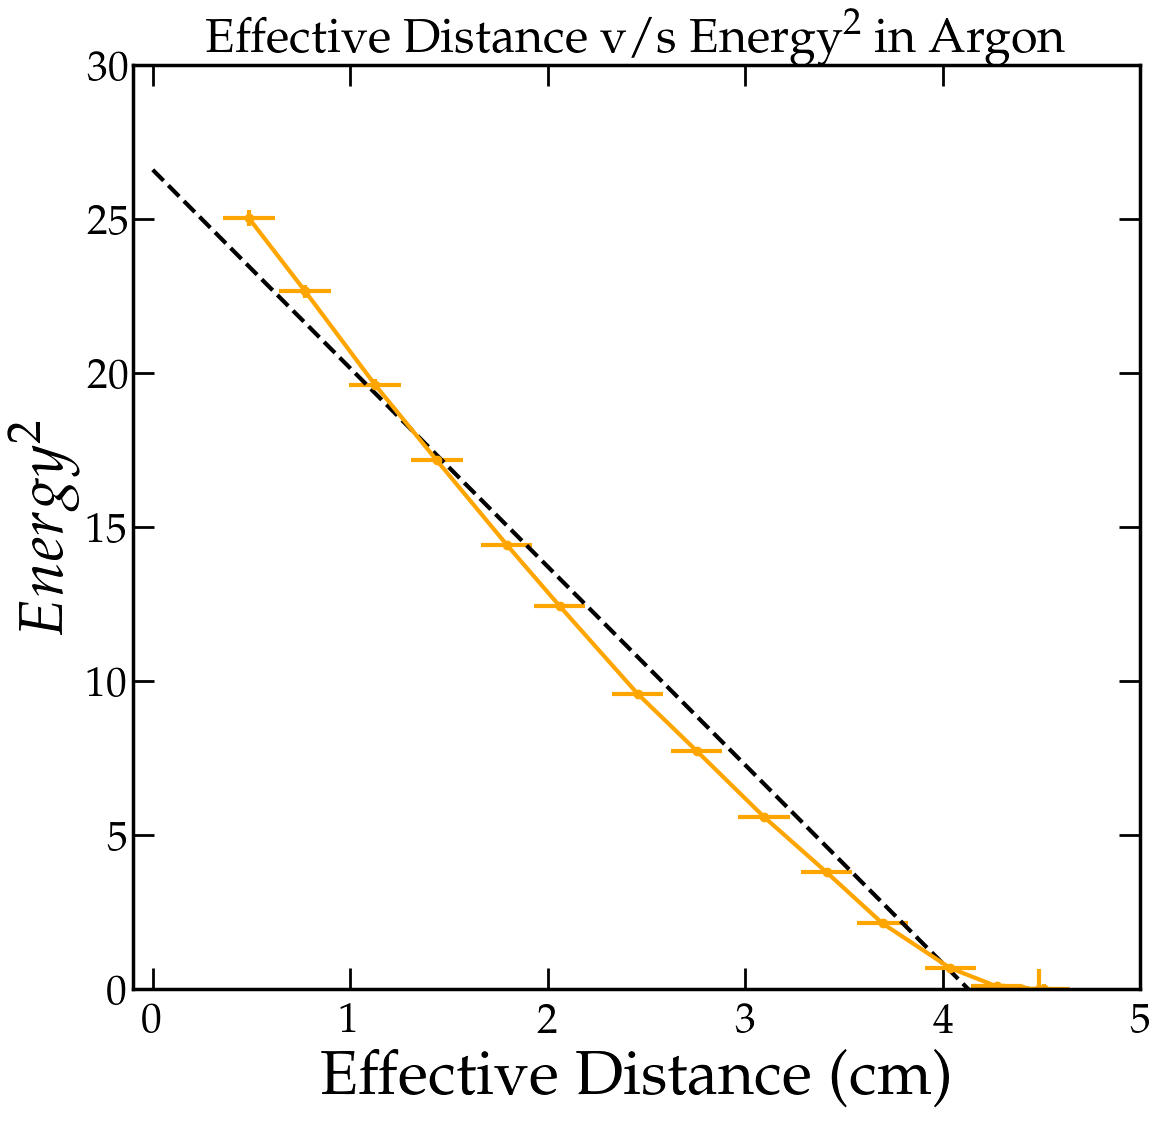

In [ ]:
plt.errorbar(x_eff_argon, np.array(energies_argon)**2, xerr= delta_x_eff_argon, yerr=np.array(energies_uncertainties_argon)**2, marker ='o', color = 'orange')

plt.xlim(-0.1, 5)
plt.ylim(0, 30)
Y_fit3 = np.polyfit(x_eff_argon[0:-3], np.array(energies_argon[0:-3])**2, 1)
xs = np.linspace(0, 5, 100)
plt.plot(xs, Y_fit3[0] * xs + Y_fit3[1], color = 'black', linestyle = '--')
plt.xlabel('Effective Distance (cm)')
plt.ylabel(r'$Energy^2$')
plt.title(r'Effective Distance v/s Energy$^2$ in Argon')
plt.savefig('./Plots/effective_distance_vs_E_argon.png', dpi = 300)

## Helium

In [ ]:
d_He = 14.7 - 6.58
err = 0.13

In [ ]:
initialPs_He = [86.5, 135.9, 200.5, 257.3, 328.5, 389.2, 442.2, 497.4, 558.9, 616.4, 672.7, 720.9, 750.9]
finalPs_He = [88.5, 137.9, 202.2, 258.9, 330.0, 390.7, 443.3, 498.4, 559.7, 616.9, 672.9, 721.0, 750.9]
Ps_He = np.array([(initial + final) / 2 for initial, final in zip(initialPs_He, finalPs_He)])
deltaPs_He = np.array([(final - initial) for initial, final in zip(initialPs_He, finalPs_He)])
x_eff_He = (d_He * Ps_He) / 763.4
delta_x_eff_He = (deltaPs_He * d_He) / 763.4
delta_x_eff_He = np.sqrt(delta_x_eff_He**2 + err**2)

In [ ]:
string_He = '../Alpha Range/Helium Pressure/HeP'
nums = [88, 137, 202, 258, 329, 390, 442, 498, 559, 616, 672, 721, 750]
filenames_He = [f"{string_He}{num}.asc" for num in nums]
peak_channels_He = []
max_counts_He = []
energies_He = []
energies_uncertainties_He = []
total_counts_list_He = []
for file in filenames_He:
    pc, mc, en, std, t = file_analysis(file)
    peak_channels_He.append(pc)
    max_counts_He.append(mc)
    energies_He.append(en)
    energies_uncertainties_He.append(std)
    total_counts_list_He.append(t)

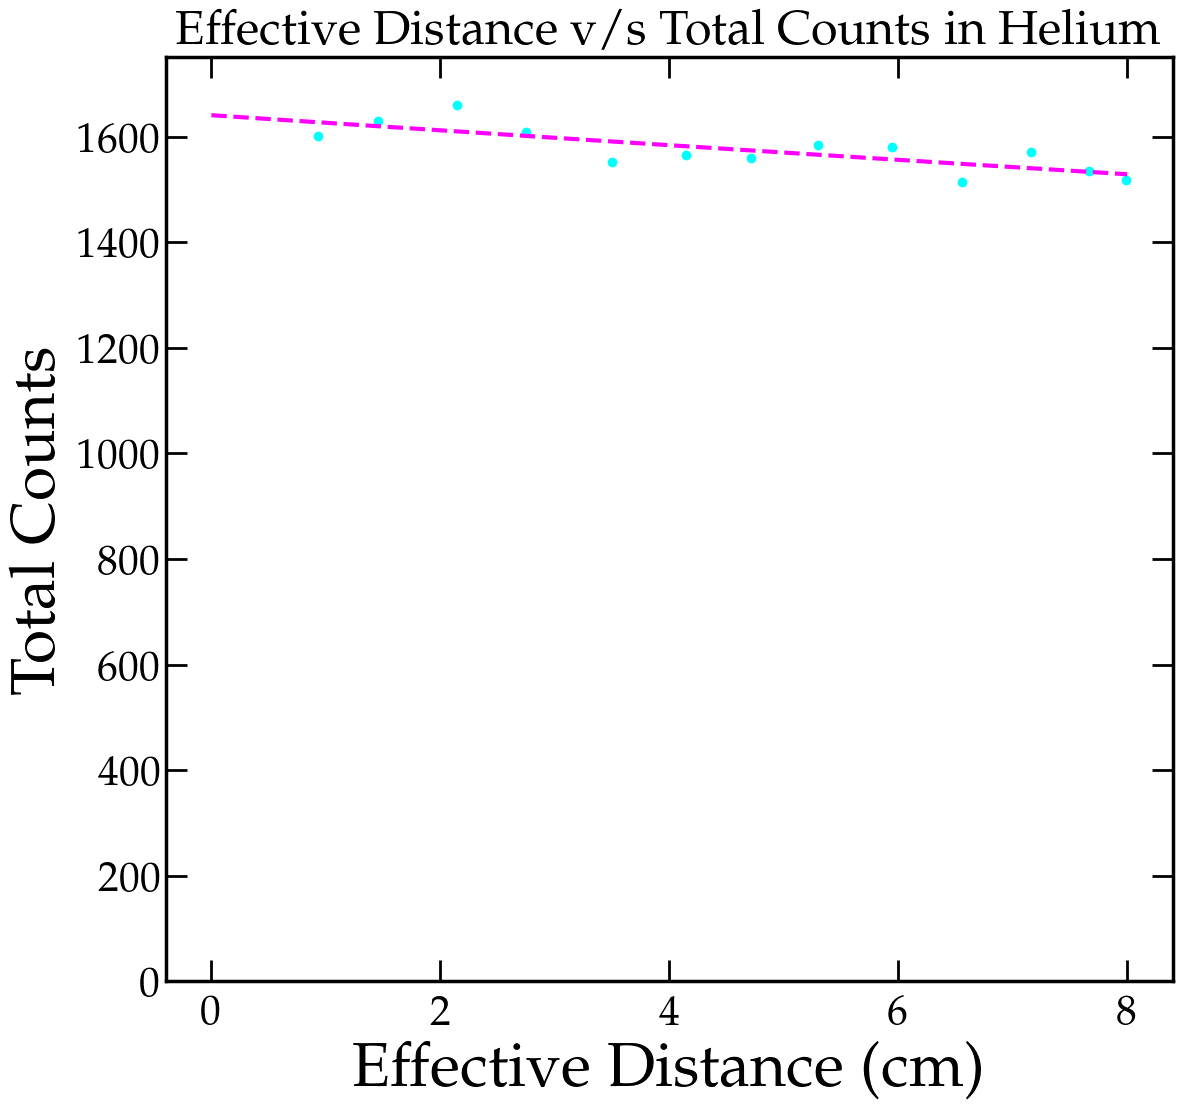

In [ ]:
plt.plot(x_eff_He, total_counts_list_He, 'o', color = 'cyan')
popt_He, pcov_He = curve_fit(erf_fit_for_total_count, x_eff_He, total_counts_list_He, p0=[5000, 1, 2], maxfev=10000)
xs = np.linspace(0, 8, 100)
plt.plot(xs, erf_fit_for_total_count(xs, *popt_He), color = 'magenta', linestyle = '--')
plt.ylim(0, 1750)
plt.xlabel('Effective Distance (cm)')
plt.ylabel('Total Counts')
plt.title('Effective Distance v/s Total Counts in Helium')
plt.savefig('./Plots/effective_distance_vs_total_counts_helium.png', dpi = 300)

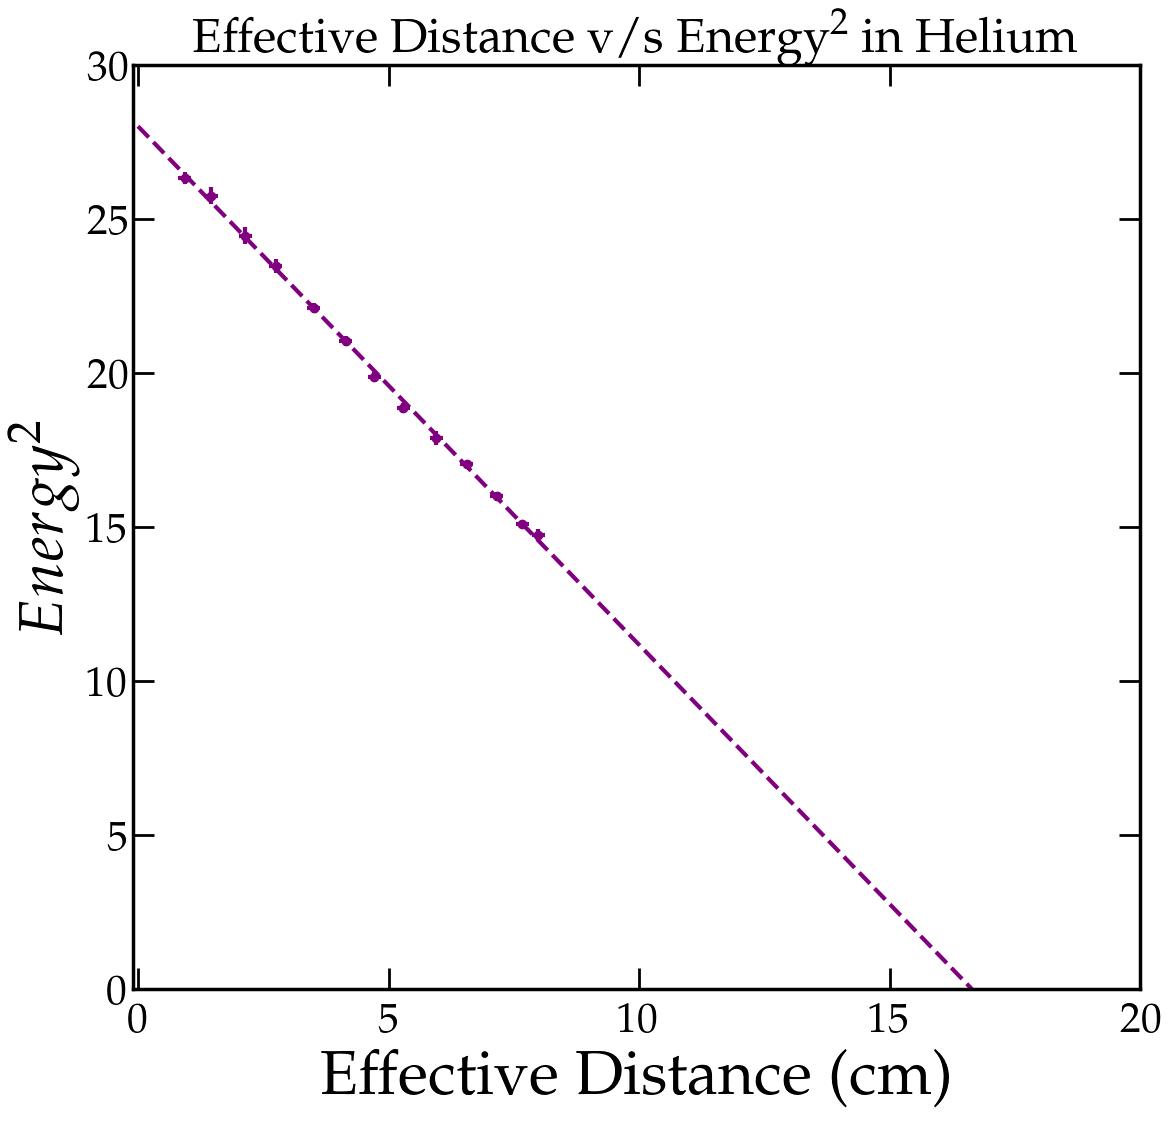

In [ ]:
# dont join the scatter points
plt.errorbar(x_eff_He, np.array(energies_He)**2, xerr= delta_x_eff_He, yerr=np.array(energies_uncertainties_He)**2, marker ='o', color = 'purple', linestyle = 'None')
#plt.errorbar(x_eff_He, np.array(energies_He)**2, xerr= delta_x_eff_He, yerr=np.array(energies_uncertainties_He)**2, marker ='o', color = 'purple')
plt.xlim(-0.1, 20)
plt.ylim(0, 30)
Y_fit4 = np.polyfit(x_eff_He, np.array(energies_He)**2, 1)
xs = np.linspace(0, 20, 100)
plt.plot(xs, Y_fit4[0] * xs + Y_fit4[1], color = 'purple', linestyle = '--')
plt.xlabel('Effective Distance (cm)')
plt.ylabel(r'$Energy^2$')
plt.title(r'Effective Distance v/s Energy$^2$ in Helium')
plt.savefig('./Plots/effective_distance_vs_E_helium.png', dpi = 300)

### Nitrogen

In [ ]:
initialPs_nitrogen = [70.9, 126.6, 180.6, 269.8, 318.2, 370.3, 429.8, 481.1, 538.6, 589.1, 640.4, 720.9, 722.8, 727.4, 735.5, 748.9, 770.1]
finalPs_nitrogen = [71.7, 127.3, 181.2, 270.3, 318.8, 370.7, 430.2, 481.4, 538.3, 589.7, 640.5, 720.9,722.8,  727.5, 748.9, 770.0 ]
Ps_nitrogen = np.array([(initial + final) / 2 for initial, final in zip(initialPs_nitrogen, finalPs_nitrogen)])
deltaPs_nitrogen = np.array([(final - initial) for initial, final in zip(initialPs_nitrogen, finalPs_nitrogen)])
d_nitrogen = 10.9 - 6.58
x_err_nitrogen = 0.13
x_eff_nitrogen = (d_nitrogen * Ps_nitrogen) / 763.4
delta_x_eff_nitrogen = (deltaPs_nitrogen * d_nitrogen) / 763.4
delta_x_eff_nitrogen = np.sqrt(delta_x_eff_nitrogen**2 + x_err_nitrogen**2)



In [ ]:
string_nitrogen = '../Alpha Range/Nitrogen Pressure/N2P'
nums_nitrogen = [71, 127, 181, 270, 318, 370, 430, 481, 538, 589, 640, 720,722, 727, 749, 770]
filenames_nitrogen = [f"{string_nitrogen}{num}.asc" for num in nums_nitrogen]
peak_channels_nitrogen = []
max_counts_nitrogen = []
energies_nitrogen = []
energies_uncertainties_nitrogen = []
total_counts_list_nitrogen = []
for file in filenames_nitrogen:
    pc, mc, en, std, t = file_analysis(file)
    peak_channels_nitrogen.append(pc)
    max_counts_nitrogen.append(mc)
    energies_nitrogen.append(en)
    energies_uncertainties_nitrogen.append(std)
    total_counts_list_nitrogen.append(t)
    

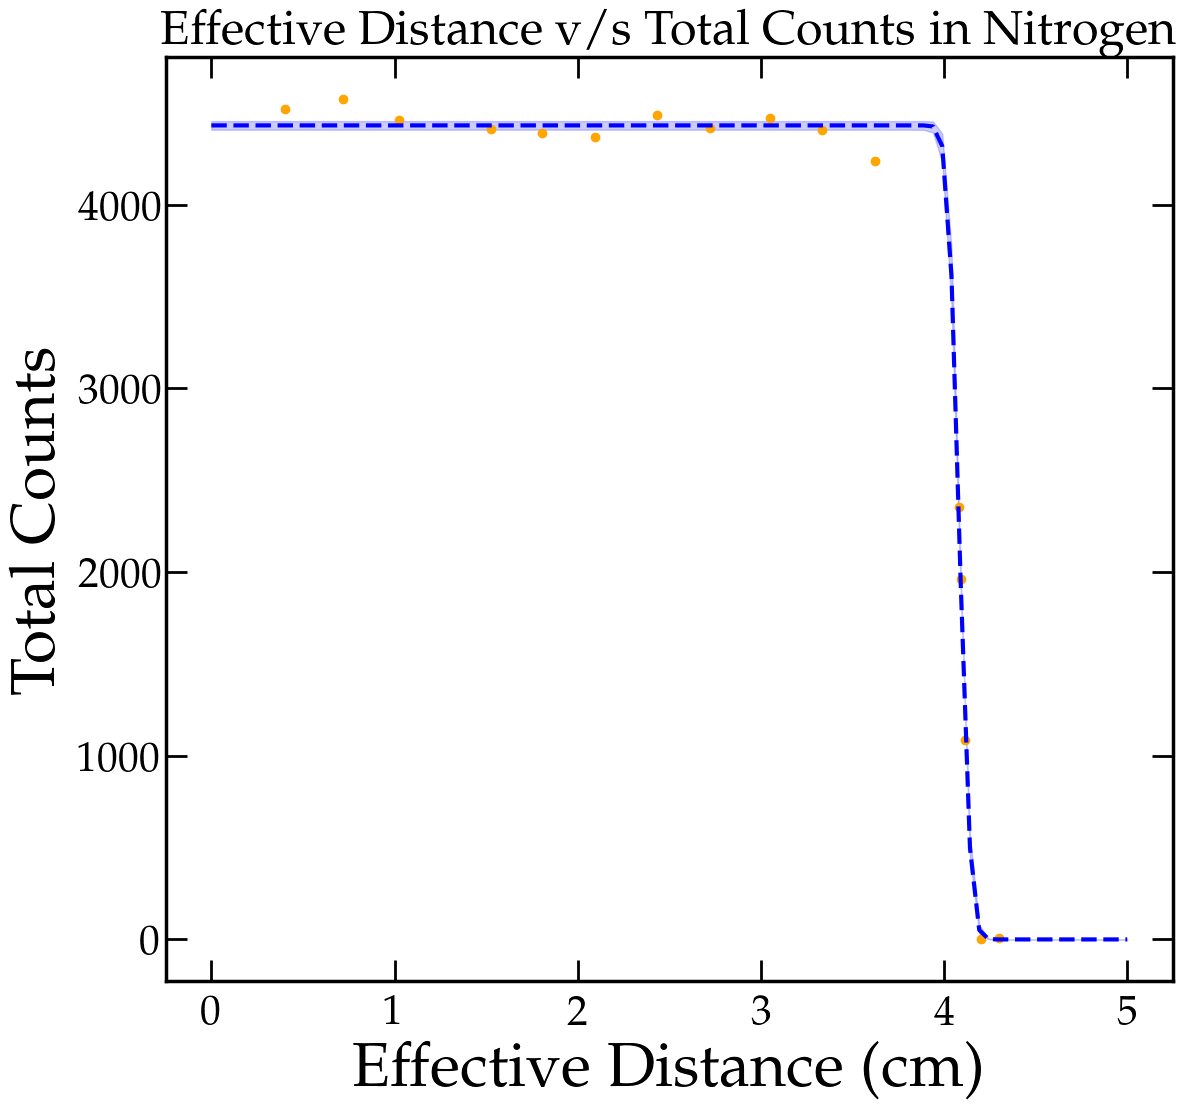

In [ ]:
plt.plot(x_eff_nitrogen, total_counts_list_nitrogen, 'o', color = 'orange')
popt, pcov = curve_fit(erf_fit_for_total_count, x_eff_nitrogen, total_counts_list_nitrogen, p0=[5000, 1, 2])
xs = np.linspace(0, 5, 100)
plt.plot(xs, erf_fit_for_total_count(xs, *popt), color = 'blue', linestyle = '--')
plt.fill_between(xs,
                        erf_fit_for_total_count(xs, *(popt + np.sqrt(np.diag(pcov)))),
                        erf_fit_for_total_count(xs, *(popt - np.sqrt(np.diag(pcov)))),
                        color='blue', alpha=0.2)
plt.xlabel('Effective Distance (cm)')
plt.ylabel('Total Counts')
plt.title('Effective Distance v/s Total Counts in Nitrogen')
plt.savefig('./Plots/effective_distance_vs_total_counts_nitrogen.png', dpi = 300)


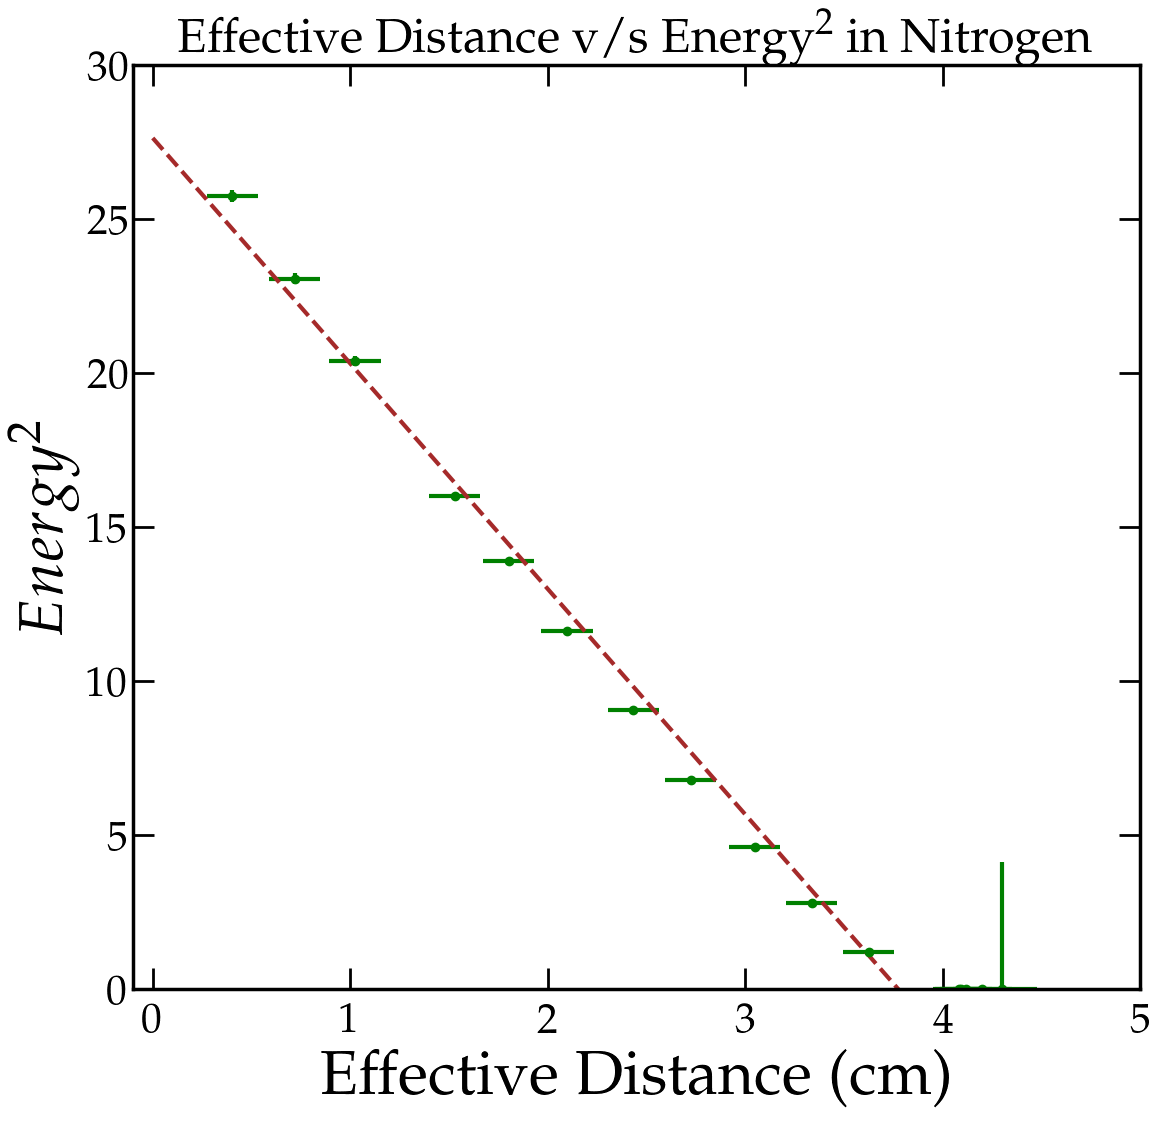

In [ ]:
plt.errorbar(x_eff_nitrogen, np.array(energies_nitrogen)**2, xerr= delta_x_eff_nitrogen, yerr=np.array(energies_uncertainties_nitrogen)**2, marker ='o', color = 'green', linestyle = 'None')
plt.xlim(-0.1, 5)
plt.ylim(0, 30)
Y_fit5 = np.polyfit(x_eff_nitrogen[0:-4], np.array(energies_nitrogen[0:-4])**2, 1)
xs = np.linspace(0, 5, 100)
plt.plot(xs, Y_fit5[0] * xs + Y_fit5[1], color = 'brown', linestyle = '--')
plt.xlabel('Effective Distance (cm)')
plt.ylabel(r'$Energy^2$')
plt.title(r'Effective Distance v/s Energy$^2$ in Nitrogen')
plt.savefig('./Plots/effective_distance_vs_E_nitrogen.png', dpi = 300)